<h1> NHL Home Win Predictor <h1>

<h2> Link to Google Sheets <h2>

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from pprint import pprint # for better looking format when data is printed

from df2gspread import df2gspread as d2g # to export dataframes back to google sheets

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets','https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

In [3]:
creds = ServiceAccountCredentials.from_json_keyfile_name("NHL-viz-data-e6a8852157c7.json", scope) # credentials
client = gspread.authorize(creds)

In [4]:
sheet = client.open("NHL_Data").worksheet('2018-19') # Indicates the worksheet name to be opened

In [5]:
results = sheet.get_all_records()

# for better looking format when data is printed
pprint(results)

'2019-04-04',
  'Game Finish': '',
  'Home': 'Buffalo Sabres',
  'Home Goals': 5,
  'Visitor': 'Ottawa Senators',
  'Visitor Goals': 2},
 {'Att.': '17,645',
  'Date': '2019-04-04',
  'Game Finish': '',
  'Home': 'Carolina Hurricanes',
  'Home Goals': 3,
  'Visitor': 'New Jersey Devils',
  'Visitor Goals': 1},
 {'Att.': '18,003',
  'Date': '2019-04-04',
  'Game Finish': 'OT',
  'Home': 'Colorado Avalanche',
  'Home Goals': 3,
  'Visitor': 'Winnipeg Jets',
  'Visitor Goals': 2},
 {'Att.': '18,347',
  'Date': '2019-04-04',
  'Game Finish': '',
  'Home': 'Edmonton Oilers',
  'Home Goals': 2,
  'Visitor': 'San Jose Sharks',
  'Visitor Goals': 3},
 {'Att.': '13,775',
  'Date': '2019-04-04',
  'Game Finish': 'SO',
  'Home': 'Florida Panthers',
  'Home Goals': 1,
  'Visitor': 'New York Islanders',
  'Visitor Goals': 2},
 {'Att.': '19,074',
  'Date': '2019-04-04',
  'Game Finish': '',
  'Home': 'Minnesota Wild',
  'Home Goals': 0,
  'Visitor': 'Boston Bruins',
  'Visitor Goals': 3},
 {'Att.': '

In [6]:
# Required Python libraries
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<h2> Importing the Dataset <h2>

In [7]:
# Imports Google sheet as pandas dataframe; 0 indicates first row/column
results = pd.DataFrame(results[0:], columns=results[0])

# The dataset contains all the games from the regular season
# By default the first row will be considered as the header
results

,Date,Visitor,Visitor Goals,Home,Home Goals,Game Finish,Att.
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,,"17,562"
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,OT,"19,589"
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,,"18,870"
3,2018-10-03,Boston Bruins,0,Washington Capitals,7,,"18,506"
4,2018-10-04,Boston Bruins,4,Buffalo Sabres,0,,"19,070"
...,...,...,...,...,...,...,...
1353,2019-06-01,Boston Bruins,7,St. Louis Blues,2,,"18,789"
1354,2019-06-03,Boston Bruins,2,St. Louis Blues,4,,"18,805"
1355,2019-06-06,St. Louis Blues,2,Boston Bruins,1,,"17,565"
1356,2019-06-09,Boston Bruins,5,St. Louis Blues,1,,"18,890"


In [8]:
# Lists data types of each column
results.dtypes.head()

Date             object
Visitor          object
Visitor Goals     int64
Home             object
Home Goals        int64
dtype: object

<h2> Data Cleaning and Manipulation <h2>

In [9]:
# Fix the names of the columns
results.columns = ["Date", "Visitor Team", "Visitor Goals", "Home Team", "Home Goals", "Game Finish", "Attendance"]

In [10]:
results.loc[:5]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,,"17,562"
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,OT,"19,589"
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,,"18,870"
3,2018-10-03,Boston Bruins,0,Washington Capitals,7,,"18,506"
4,2018-10-04,Boston Bruins,4,Buffalo Sabres,0,,"19,070"
5,2018-10-04,New York Islanders,2,Carolina Hurricanes,1,OT,"18,680"


In [11]:
# Fills empty rows in 'Game Finish' column with NaN by adding in 'REG' for regulation win
results["Game Finish"] = results["Game Finish"].replace("", "REG")

In [12]:
results.head()

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,REG,"17,562"
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,OT,"19,589"
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,REG,"18,870"
3,2018-10-03,Boston Bruins,0,Washington Capitals,7,REG,"18,506"
4,2018-10-04,Boston Bruins,4,Buffalo Sabres,0,REG,"19,070"


<h2> Creating the attribute to predict: Home Win <h2>


The purpose of this analysis is to predict whether the Home Team won their match. The following creates the "Home Win" column.

In [13]:
# Create a new attribute called "Home Win" to show if the home team won the game
results["Home Win"] = results["Visitor Goals"] < results["Home Goals"]

# This will be the class we are trying to predict for our model, whether the home team won or not
y_true = results["Home Win"].values

In [14]:
results.loc[:5]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,REG,"17,562",False
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,OT,"19,589",True
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,REG,"18,870",True
3,2018-10-03,Boston Bruins,0,Washington Capitals,7,REG,"18,506",True
4,2018-10-04,Boston Bruins,4,Buffalo Sabres,0,REG,"19,070",False
5,2018-10-04,New York Islanders,2,Carolina Hurricanes,1,OT,"18,680",False


In [15]:
# y_true is the object that stores all values for the Home Win column for each game in the dataset
y_true

array([False,  True,  True, ..., False, False, False])

<h2> Creating the Performance Indicator: the F1 score <h2>


The F1 Score will be used as the key metric to compare classifiers. It considers both recall and precision.

In [16]:
# The classification report and the F1 score metric will both be used to show the performance of our model
from sklearn.metrics import f1_score, make_scorer, classification_report

# The scorer object created below will be designated with the F1 score
scorer = make_scorer(f1_score, pos_label=None, average='weighted')

<h2> Creating a baseline to beat <h2> 

In [17]:
# Counts the number of rows in the 'Home Win' column
n_games = results["Home Win"].count()
# Adds the number of 'True' there are in the 'Home Win' column
n_homewins = results["Home Win"].sum()

win_percentage = n_homewins / n_games

print("Overall Home Win Percentage in Dataset: {0:.1f}%".format(100 * win_percentage))

Overall Home Win Percentage in Dataset: 53.5%


In [18]:
n_games

1358

In [19]:
n_homewins 

727

Note: 53.5% is the chance the guess will be correct if a random game were to be picked and guessed if the home team won.

In [20]:
from sklearn.metrics import f1_score
y_pred = [1] * len(y_true)
print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, pos_label=None, average="weighted")))

F1 Score: 0.3733


A model has to be built which produces a better F1 Score than 0.3733.

<h2> Feature Engineering to Improve Model Prediction <h2>

<h3> Feature 1: Win Streaks for the each team <h3>

This feature will keep a running win streak for each team by accounting for when that team was at home and away games.

In [21]:
# Set new win streak feature with a default value of 0
results["Home Win Streak"] = 0
results["Visitor Win Streak"] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in results.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    results.loc[index] = row
    
    if row["Home Win"]:
        win_streak[home_team] += 1 # if "Home Win" is True, increase home_team by 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1 # if "Home Win" is False, increase visitor_team by 1

In [22]:
results.loc[5:15]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win,Home Win Streak,Visitor Win Streak
5,2018-10-04,New York Islanders,2,Carolina Hurricanes,1,OT,"18,680",False,0,0
6,2018-10-04,Minnesota Wild,1,Colorado Avalanche,4,REG,"18,086",True,0,0
7,2018-10-04,Arizona Coyotes,0,Dallas Stars,3,REG,"18,532",True,0,0
8,2018-10-04,Columbus Blue Jackets,3,Detroit Red Wings,2,OT,"19,515",False,0,0
9,2018-10-04,Nashville Predators,3,New York Rangers,2,REG,"17,117",False,0,0
10,2018-10-04,Chicago Blackhawks,4,Ottawa Senators,3,OT,"15,858",False,0,0
11,2018-10-04,Washington Capitals,6,Pittsburgh Penguins,7,OT,"18,627",True,0,1
12,2018-10-04,Winnipeg Jets,5,St. Louis Blues,1,REG,"18,292",False,0,0
13,2018-10-04,Philadelphia Flyers,5,Vegas Golden Knights,2,REG,"18,555",False,0,0
14,2018-10-05,Carolina Hurricanes,3,Columbus Blue Jackets,1,REG,"18,306",False,1,0


<h3> Feature 2: Whether the home or visitor team won their last game <h3>

This feature indicates if the home team or the visitor team in the game won their last game.
For example, if the Toronto Maple Leafs are the home team for the game and they won their last game, whether it was at home or away, Home Last Win would be TRUE.
If the Toronto Maple Leafs are the visitor team for the game and they won their last game, whether it was at home or away, Visitor Last Win would be TRUE.

In [23]:
# Create Home Last Win and Visitor Last Win
results["Home Last Win"] = False
results["Visitor Last Win"] = False

won_last = defaultdict(int)

for index, row in results.iterrows(): # for each row
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Last Win"] = won_last[home_team]
    row["Visitor Last Win"] = won_last[visitor_team]
    results.loc[index] = row
    # Set which team won
    won_last[home_team] = row["Home Win"] # set Home Last Win as True if "Home Win" is True
    won_last[visitor_team] = not row["Home Win"] # otherwise set "Visitor Last Win" as True

In [24]:
results.loc[5:15]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win,Home Win Streak,Visitor Win Streak,Home Last Win,Visitor Last Win
5,2018-10-04,New York Islanders,2,Carolina Hurricanes,1,OT,"18,680",False,0,0,0,0
6,2018-10-04,Minnesota Wild,1,Colorado Avalanche,4,REG,"18,086",True,0,0,0,0
7,2018-10-04,Arizona Coyotes,0,Dallas Stars,3,REG,"18,532",True,0,0,0,0
8,2018-10-04,Columbus Blue Jackets,3,Detroit Red Wings,2,OT,"19,515",False,0,0,0,0
9,2018-10-04,Nashville Predators,3,New York Rangers,2,REG,"17,117",False,0,0,0,0
10,2018-10-04,Chicago Blackhawks,4,Ottawa Senators,3,OT,"15,858",False,0,0,0,0
11,2018-10-04,Washington Capitals,6,Pittsburgh Penguins,7,OT,"18,627",True,0,1,0,True
12,2018-10-04,Winnipeg Jets,5,St. Louis Blues,1,REG,"18,292",False,0,0,0,0
13,2018-10-04,Philadelphia Flyers,5,Vegas Golden Knights,2,REG,"18,555",False,0,0,0,0
14,2018-10-05,Carolina Hurricanes,3,Columbus Blue Jackets,1,REG,"18,306",False,1,0,True,False


<h3> Feature 3: Whether the home team beat the visitor team when they both played last <h3>

In [25]:
last_match_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    # Sort team names for a consistent ordering (sorts by alphabetical order)
    teams = tuple(sorted([home_team, visitor_team]))
    
    # If the home team won the previous game, the "result" will be 1
    result = 1 if last_match_winner[teams] == row["Home Team"] else 0
    
    # Update record for next encounter
    winner = row["Home Team"] if row["Home Win"] else row["Visitor Team"]
    
    last_match_winner[teams] = winner
    return result

results["Home Team Won Last"] = results.apply(home_team_won_last, axis=1)

In [26]:
results[45:55]

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win,Home Win Streak,Visitor Win Streak,Home Last Win,Visitor Last Win,Home Team Won Last
45,2018-10-11,Colorado Avalanche,6,Buffalo Sabres,1,REG,"15,396",False,2,0,True,False,0
46,2018-10-11,Toronto Maple Leafs,5,Detroit Red Wings,3,REG,"19,515",False,0,2,False,True,0
47,2018-10-11,Columbus Blue Jackets,5,Florida Panthers,4,REG,"14,394",False,0,1,False,True,0
48,2018-10-11,Chicago Blackhawks,3,Minnesota Wild,4,OT,"18,652",True,0,0,False,False,0
49,2018-10-11,Los Angeles Kings,3,Montreal Canadiens,0,REG,"21,302",False,1,0,True,False,0
50,2018-10-11,Washington Capitals,0,New Jersey Devils,6,REG,"16,514",True,1,1,True,True,0
51,2018-10-11,Winnipeg Jets,0,Nashville Predators,3,REG,"17,228",True,0,1,False,True,0
52,2018-10-11,San Jose Sharks,2,New York Rangers,3,OT,"17,004",True,0,1,False,True,0
53,2018-10-11,Vegas Golden Knights,2,Pittsburgh Penguins,4,REG,"18,610",True,0,0,False,False,0
54,2018-10-11,Calgary Flames,3,St. Louis Blues,5,REG,"16,403",True,0,2,False,True,0


In [27]:
# Exports dataframe onto google sheets file
spreadsheet_key = '1Pk9_A7RvpF2VgFVjUvIx5DapZAIf8NDoDm3zzw2xKNg' # from spreadsheet URL
wks_name = '2018-19 Edited' # Creates new spreadsheet titled '2018-19 Edited'
d2g.upload(results, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet '2018-19 Edited' id:1898942167>

In [28]:
# Filters the columns to show columns that are requested only
results[55:75][['Date', 'Home Team', 'Home Goals', 'Visitor Team', 'Visitor Goals', 'Home Win', 'Home Win Streak', 'Home Team Won Last', 'Home Last Win']]

,Date,Home Team,Home Goals,Visitor Team,Visitor Goals,Home Win,Home Win Streak,Home Team Won Last,Home Last Win
55,2018-10-11,Tampa Bay Lightning,1,Vancouver Canucks,4,False,1,0,True
56,2018-10-13,Arizona Coyotes,0,Buffalo Sabres,3,False,1,0,True
57,2018-10-13,Boston Bruins,8,Detroit Red Wings,2,True,3,0,True
58,2018-10-13,Chicago Blackhawks,4,St. Louis Blues,3,True,0,1,False
59,2018-10-13,Colorado Avalanche,2,Calgary Flames,3,False,1,0,True
60,2018-10-13,Dallas Stars,5,Anaheim Ducks,3,True,0,0,False
61,2018-10-13,Florida Panthers,2,Vancouver Canucks,3,False,0,0,False
62,2018-10-13,Minnesota Wild,4,Carolina Hurricanes,5,False,1,0,True
63,2018-10-13,Montreal Canadiens,4,Pittsburgh Penguins,3,True,0,1,False
64,2018-10-13,Nashville Predators,5,New York Islanders,2,True,1,1,True


<h2> Correlaton Visual <h2>

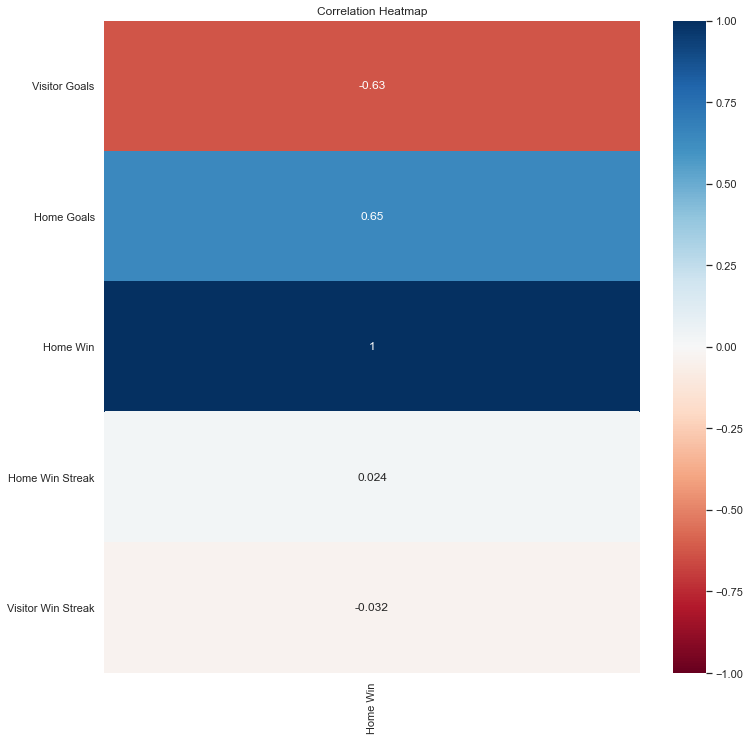

In [29]:
# Heatmap for correlations
plt.figure(figsize = (12, 12))
s = sns.heatmap(results.corr()[['Home Win']][0:5], # Indicates columns to include in heatmap
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

As seen above, when it comes to predicting a home win:
- More home goals can greatly increase the likelihood of a home win, while more goals from the visitor team can greatly reduce the likelihood of a home win as expected.
- Home or Win Streaks do not have significant impacts as their correlations are small even though they are home win streaks are positively correlated and visitor win streaks are negatively correlated.

<h2> Further Data Manipulation: Converting team names to team IDs using Encoding <h2>

Team names are stored as strings (e.g. "Toronto Maple Leafs") and classification methods do not work too well with strings.

By using the 'one hot encoder' feature provided by Scikit-Learn, team names can be labelled in a numeric fashion so that the classifier can understand them and potentially provide much more information to our model in determining winners.

In [30]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoding = LabelEncoder() # encoding object has LabelEncoder ready to use
encoding.fit(results["Home Team"].values) # give each team a number to identify them by

LabelEncoder()

In [31]:
# This will assign each team name a value to use instead of the string itself. Better to work with numbers than strings.
home_teams = encoding.transform(results["Home Team"].values)
visitor_teams = encoding.transform(results["Visitor Team"].values)

# vstack allows you to stack a sequence of arrays vertically - in this case we do it to make easy comparisons
X_teams = np.vstack([home_teams, visitor_teams]).T # transpose

X_teams[:6], X_teams.shape

(array([[23,  0],
        [26, 15],
        [27,  4],
        [29,  2],
        [ 3,  2],
        [ 5, 18]]),
 (1358, 2))

Home Team and Visitor Teams are displayed in the same order as the above array.

In [32]:
results["Home Team"].values

array(['San Jose Sharks', 'Toronto Maple Leafs', 'Vancouver Canucks', ...,
       'Boston Bruins', 'St. Louis Blues', 'Boston Bruins'], dtype=object)

In [33]:
results["Visitor Team"].values

array(['Anaheim Ducks', 'Montreal Canadiens', 'Calgary Flames', ...,
       'St. Louis Blues', 'Boston Bruins', 'St. Louis Blues'],
      dtype=object)

In [35]:
# Data Cleaning: Remove commas in attendance column
results["Attendance"] = results["Attendance"].str.replace(",","")

In [36]:
results.head()

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win,Home Win Streak,Visitor Win Streak,Home Last Win,Visitor Last Win,Home Team Won Last
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,1,17562,False,0,0,0,0,0
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,2,19589,True,0,0,0,0,0
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,1,18870,True,0,0,0,0,0
3,2018-10-03,Boston Bruins,0,Washington Capitals,7,1,18506,True,0,0,0,0,0
4,2018-10-04,Boston Bruins,4,Buffalo Sabres,0,1,19070,False,0,0,0,False,0


In [37]:
# To get rid of any infinite values in the dataframe
results.replace([np.inf, -np.inf], np.nan, inplace=True)

In [38]:
# To get rid of any null values in the dataframe
results.fillna(results.mean(), inplace=True)

In [39]:
X_needed_features = results[['Home Win Streak', 'Home Last Win', 'Home Team Won Last']].values

In [40]:
# Combines everything
X_all = np.hstack([X_needed_features, X_teams])
X_all.shape

(1358, 5)

<h2> Creating the Training/Testing Dataset Split <h2>

In [41]:
# Data Splicing: the split is 70% training set and 30% testing set
# y_true created earlier above is the object that stores all values for the Home Win column for each game in the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_true, test_size=0.3, stratify = y_true, random_state=10)

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
X_train.shape

(950, 5)

In [44]:
Y_train.shape

(950,)

<h1> Classification using various Model Algorithms <h1>

<h2> Classification with Decision Trees <h2>

The Decision Tree Classifier will be used as the model to predict which team won the game.

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics # for accuracy calculation
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
# Create Decision Tree classifer object
DT = DecisionTreeClassifier()

# Train Decision Tree Classifer
DT = DT.fit(X_train,Y_train)

# Predict the response for test dataset
y_pred = DT.predict(X_test)

In [47]:
# y_true is the object containing the Home Win column
scores = cross_val_score(DT, X_all, y_true)
print("The F1 score using Decision Tree Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using Decision Tree Classifier is the following: 0.4956


In [48]:
print(confusion_matrix(Y_test, y_pred))

[[ 80 110]
 [103 115]]


In [49]:
print(metrics.classification_report(Y_test, y_pred))

precision    recall  f1-score   support

       False       0.44      0.42      0.43       190
        True       0.51      0.53      0.52       218

    accuracy                           0.48       408
   macro avg       0.47      0.47      0.47       408
weighted avg       0.48      0.48      0.48       408



<h2> Classification with Random Forests <h2>

In [50]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Create Random Forests classifer object
RF = RandomForestClassifier(n_estimators=10)

# Train Random Forests Classifer
RF = RF.fit(X_train, Y_train)

# Predict the response for test dataset
y_pred = RF.predict(X_test)

In [51]:
scores = cross_val_score(RF, X_all, y_true)
print("The F1 score using Random Forest Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using Random Forest Classifier is the following: 0.5015


<h2> GridSearchCV with Random Forests Classifier <h2>

In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
# Will take some time to run; used to prevent overfitting
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1,2,4,6],
}

In [54]:
RF = RandomForestClassifier()
grid = GridSearchCV(RF, parameter_space)
grid.fit(X_all, y_true)

# View results
print("F1: {0:.4f}".format(grid.best_score_))
print(grid.best_estimator_) # Indicates best options used for the random forests classifier based on the options given in the parameter_space

F1: 0.5088
RandomForestClassifier(min_samples_leaf=4)


Using GridSearchCV improved the F1 score of the random forests classifier.

<h2> Naive Bayes Classifier <h2>

In [55]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# fit a Naive Bayes model to the data
NB = GaussianNB()

NB.fit(X_train, Y_train)
print(NB)


GaussianNB()


In [56]:
scores = cross_val_score(NB, X_all, y_true)
print("The F1 score using Naive Bayes Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using Naive Bayes Classifier is the following: 0.5221


<h2> K Nearest Neighbour (KNN) <h2>

In [57]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=5) # sets k=5
KNN.fit(X_train, Y_train)

KNeighborsClassifier()

In [58]:
y_pred = KNN.predict(X_test)

In [59]:
scores = cross_val_score(KNN, X_all, y_true)
print("The F1 score using KNN Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using KNN Classifier is the following: 0.5184


In [60]:
print(confusion_matrix(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

[[ 82 108]
 [ 92 126]]
              precision    recall  f1-score   support

       False       0.47      0.43      0.45       190
        True       0.54      0.58      0.56       218

    accuracy                           0.51       408
   macro avg       0.50      0.50      0.50       408
weighted avg       0.51      0.51      0.51       408



The results show the KNN algorithm was able to classify all the 408 records in the test set with 92% accuracy.

<h2> Support Vector Machine (SVM) <h2>

In [61]:
# Import SVM model
from sklearn import svm

# Create a SVM Classifier
SVM = svm.SVC(kernel='linear') # Linear Kernel

SVM.fit(X_train, Y_train)

y_pred = SVM.predict(X_test)

In [62]:
scores = cross_val_score(SVM, X_all, y_true)
print("The F1 score using SVM Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using SVM Classifier is the following: 0.5353


In [63]:
print(confusion_matrix(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

[[  0 190]
 [  0 218]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       190
        True       0.53      1.00      0.70       218

    accuracy                           0.53       408
   macro avg       0.27      0.50      0.35       408
weighted avg       0.29      0.53      0.37       408



<h2> Boosting <h2>

In [64]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
X_test.shape

(408, 5)

In [66]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=1)
AdaBoost = AdaBoostClassifier(base_estimator=model, n_estimators=400, learning_rate=1)

boostmodel = AdaBoost.fit(X_train, Y_train)

y_pred = boostmodel.predict(X_test)

In [67]:
scores = cross_val_score(AdaBoost, X_all, y_true)
print("The F1 score using Adaptive Boosting Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using Adaptive Boosting Classifier is the following: 0.5434


Accuracy when using boosting algorithms is expected to be 100%,. When you use weak learner models with decision trees, accuracy is not as high due to factors such as overfitting. Boosting algorithms would be the alternative, which usually increases the accuracy.

<h2> Summary of Individual Model Performances <h2>

Final Results Summarized Below:

Note:
DT = Decision Tree,
RF = Random Forest,
NB = Naive Bayes,
KNN = K Nearest Neighbours,
SVM = Support Vector Machine,
AdaBoost = Adaptive Boosting Algorithm

<AxesSubplot:>

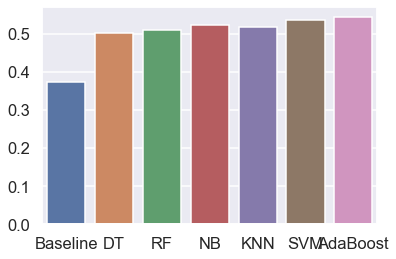

In [68]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# RF value uses GridSearchCV
labels = ["Baseline", "DT", "RF", "NB", "KNN", "SVM", "AdaBoost"]
scores = [0.3733, 0.5008, 0.5103, 0.5221, 0.5184, 0.5353, 0.5434]

sns.set(style="darkgrid", context="talk")
sns.barplot(labels, scores)

The best model is AdaBoost as it has the highest F1 score relative to the other classifiers utilized.

<h2> Storing preferred classification model using pickle <h2>

In [95]:
# To serialize data in its current state and store for future state
import pickle
filename = 'model' # Name of file in folder
outfile = open(filename, 'wb') # wb

# Pickles the classification model into the 'model' file
pickle.dump(boostmodel, outfile)
outfile.close()

<h2> Forecasting: Testing the Best Model on the 2019-2020 Regular Season <h2>

In [70]:
# Imports new dataset for 2019-2020 regular season
# Note this season ended in March due to COVID-19, so dataset size is less.
sheet2 = client.open("NHL_Data").worksheet('2019-20') # Indicates the worksheet name to be opened

In [71]:
results_new = sheet2.get_all_records()

# for better looking format when data is printed
pprint(results_new)

Home': 'New York Islanders',
  'Home Goals': 4,
  'Visitor': 'San Jose Sharks',
  'Visitor Goals': 1},
 {'Att.': 18573,
  'Date': '2020-02-23',
  'Game Finish': '',
  'Home': 'Washington Capitals',
  'Home Goals': 5,
  'Visitor': 'Pittsburgh Penguins',
  'Visitor Goals': 3},
 {'Att.': 17518,
  'Date': '2020-02-24',
  'Game Finish': 'OT',
  'Home': 'Columbus Blue Jackets',
  'Home Goals': 4,
  'Visitor': 'Ottawa Senators',
  'Visitor Goals': 3},
 {'Att.': 15431,
  'Date': '2020-02-25',
  'Game Finish': 'OT',
  'Home': 'Anaheim Ducks',
  'Home Goals': 4,
  'Visitor': 'Edmonton Oilers',
  'Visitor Goals': 3},
 {'Att.': 12391,
  'Date': '2020-02-25',
  'Game Finish': '',
  'Home': 'Arizona Coyotes',
  'Home Goals': 1,
  'Visitor': 'Florida Panthers',
  'Visitor Goals': 2},
 {'Att.': 17850,
  'Date': '2020-02-25',
  'Game Finish': '',
  'Home': 'Boston Bruins',
  'Home Goals': 2,
  'Visitor': 'Calgary Flames',
  'Visitor Goals': 5},
 {'Att.': 18176,
  'Date': '2020-02-25',
  'Game Finish': 

In [72]:
# Imports Google sheet as pandas dataframe; 0 indicates first row/column
results_new = pd.DataFrame(results_new[0:], columns=results_new[0])

# The dataset contains all the games from the regular season
# By default the first row will be considered as the header
results_new

,Date,Visitor,Visitor Goals,Home,Home Goals,Game Finish,Att.
0,2019-10-02,Vancouver Canucks,2,Edmonton Oilers,3,,18347
1,2019-10-02,Washington Capitals,3,St. Louis Blues,2,OT,18096
2,2019-10-02,Ottawa Senators,3,Toronto Maple Leafs,5,,19612
3,2019-10-02,San Jose Sharks,1,Vegas Golden Knights,4,,18588
4,2019-10-03,Arizona Coyotes,1,Anaheim Ducks,2,,17174
...,...,...,...,...,...,...,...
1077,2020-03-11,St. Louis Blues,4,Anaheim Ducks,2,,16195
1078,2020-03-11,San Jose Sharks,2,Chicago Blackhawks,6,,21275
1079,2020-03-11,New York Rangers,2,Colorado Avalanche,3,OT,18025
1080,2020-03-11,Winnipeg Jets,4,Edmonton Oilers,2,,17165


In [74]:
# Fix the names of the columns for new dataset
results_new.columns = ["Date", "Visitor Team", "Visitor Goals", "Home Team", "Home Goals", "Game Finish", "Attendance"]

In [75]:
# Fills empty rows in 'Game Finish' column with NaN by adding in 'REG' for regulation win
results_new["Game Finish"] = results_new["Game Finish"].replace("", "REG")

In [76]:
results_new

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance
0,2019-10-02,Vancouver Canucks,2,Edmonton Oilers,3,REG,18347
1,2019-10-02,Washington Capitals,3,St. Louis Blues,2,OT,18096
2,2019-10-02,Ottawa Senators,3,Toronto Maple Leafs,5,REG,19612
3,2019-10-02,San Jose Sharks,1,Vegas Golden Knights,4,REG,18588
4,2019-10-03,Arizona Coyotes,1,Anaheim Ducks,2,REG,17174
...,...,...,...,...,...,...,...
1077,2020-03-11,St. Louis Blues,4,Anaheim Ducks,2,REG,16195
1078,2020-03-11,San Jose Sharks,2,Chicago Blackhawks,6,REG,21275
1079,2020-03-11,New York Rangers,2,Colorado Avalanche,3,OT,18025
1080,2020-03-11,Winnipeg Jets,4,Edmonton Oilers,2,REG,17165


In [77]:
# Create a new attribute called "Home Win" to show which team won that game for new dataset
results_new["Home Win"] = results_new["Visitor Goals"] < results_new["Home Goals"]

In [78]:
# Create Home Last Win and Visitor Last Win
results_new["Home Last Win"] = False
results_new["Visitor Last Win"] = False

won_last = defaultdict(int)

for index, row in results_new.iterrows(): # for each row
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Last Win"] = won_last[home_team]
    row["Visitor Last Win"] = won_last[visitor_team]
    results_new.loc[index] = row
    # Set which team won
    won_last[home_team] = row["Home Win"] # set Home Last Win as True if "Home Win" is True
    won_last[visitor_team] = not row["Home Win"] # otherwise set "Visitor Last Win" as True

In [79]:
# Set new win streak feature with a default value of 0 for new dataset
results_new["Home Win Streak"] = 0
results_new["Visitor Win Streak"] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in results_new.iterrows(): # Similar to before
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    results_new.loc[index] = row
    
    if row["Home Win"]:
        win_streak[home_team] += 1 # if "Home Win" is True, increase home_team by 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1 # if "Home Win" is False, increase visitor_team by 1

In [80]:
# Create Home Team Won Last feature
last_match_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    # Sort team names for a consistent ordering (sorts by alphabetical order)
    teams = tuple(sorted([home_team, visitor_team]))
    
    # If the home team won the previous game, the "result" will be 1
    result = 1 if last_match_winner[teams] == row["Home Team"] else 0
    
    # Update record for next encounter
    winner = row["Home Team"] if row["Home Win"] else row["Visitor Team"]
    
    last_match_winner[teams] = winner
    return result

results_new["Home Team Won Last"] = results_new.apply(home_team_won_last, axis=1)

In [81]:
results_new

,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win,Home Last Win,Visitor Last Win,Home Win Streak,Visitor Win Streak,Home Team Won Last
0,2019-10-02,Vancouver Canucks,2,Edmonton Oilers,3,REG,18347,True,0,0,0,0,0
1,2019-10-02,Washington Capitals,3,St. Louis Blues,2,OT,18096,False,0,0,0,0,0
2,2019-10-02,Ottawa Senators,3,Toronto Maple Leafs,5,REG,19612,True,0,0,0,0,0
3,2019-10-02,San Jose Sharks,1,Vegas Golden Knights,4,REG,18588,True,0,0,0,0,0
4,2019-10-03,Arizona Coyotes,1,Anaheim Ducks,2,REG,17174,True,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,2020-03-11,St. Louis Blues,4,Anaheim Ducks,2,REG,16195,False,True,False,1,0,0
1078,2020-03-11,San Jose Sharks,2,Chicago Blackhawks,6,REG,21275,True,False,False,0,0,0
1079,2020-03-11,New York Rangers,2,Colorado Avalanche,3,OT,18025,True,False,True,0,1,0
1080,2020-03-11,Winnipeg Jets,4,Edmonton Oilers,2,REG,17165,False,False,True,0,3,1


In [82]:
# Exports dataframe onto google sheets file
spreadsheet_key = '1Pk9_A7RvpF2VgFVjUvIx5DapZAIf8NDoDm3zzw2xKNg' # from spreadsheet URL
wks_name = '2019-20 Edited' # Creates new spreadsheet titled '2019-20 Edited'
d2g.upload(results_new, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet '2019-20 Edited' id:669205449>

In [83]:
# Puts all needed features into one object
X_needed_features_new = results_new[['Home Win Streak', 'Home Last Win', 'Home Team Won Last']]

In [84]:
# Encoding new dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
home_teams_new = encoding.transform(results_new["Home Team"].values)
visitor_teams_new = encoding.transform(results_new["Visitor Team"].values)
X_teams_new = np.vstack([home_teams_new, visitor_teams_new]).T

In [85]:
X_teams_new.shape

(1082, 2)

In [86]:
# Combining everything
X_all_new = np.hstack([X_needed_features_new, X_teams_new])
X_all_new.shape

(1082, 5)

<h2> 2019-2020 Season Baseline <h2>

In [87]:
y_true_new = results_new["Home Win"].values

In [86]:
y_true_new.shape

(1082,)

In [88]:
print("Home team wins {:.2f}% of matches".format(100*np.mean(y_true_new)))
y_pred = [1] * len(y_true_new)
print("F1 Score: {:.4f}".format(f1_score(y_true_new, y_pred, pos_label=None, average='weighted')))
print(classification_report(y_true_new, y_pred))

Home team wins 53.33% of matches
F1 Score: 0.3709
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       505
        True       0.53      1.00      0.70       577

    accuracy                           0.53      1082
   macro avg       0.27      0.50      0.35      1082
weighted avg       0.28      0.53      0.37      1082



The baseline F1 score for the 2019-2020 regular season is 0.3709. The preferred model, which uses the adaptive boosting algorithm, must have a higher F1 score than 0.3709.

<h2> Implementing the Preferred Model from the Previous Season <h2>

In [98]:
# Using the pickled model to predict the new season results
infile = open(filename, 'rb')
model = pickle.load(infile) # Loads classficiation model from 'model' file into object called model 
y_pred = model.predict(X_all_new)

In [99]:
print(classification_report(y_true_new, y_pred))

precision    recall  f1-score   support

       False       0.48      0.92      0.63       505
        True       0.64      0.13      0.21       577

    accuracy                           0.50      1082
   macro avg       0.56      0.52      0.42      1082
weighted avg       0.57      0.50      0.41      1082



In [100]:
print("This results in getting {:.1f}% of predictions correct!".format(100*np.mean(y_pred == y_true_new)))

This results in getting 49.6% of predictions correct!


In [101]:
infile.close()

<h2> Data Preparation for Tableau <h2>

In [91]:
# To use 1 core core in the cpu
n_jobs=1

In [ ]:
import numpy as np
import pandas as pd

<h3> Importing and Combining all regular season worksheets into a single pandas dataframe <h3>

In [156]:
df = pd.read_excel('D:/NHL/NHL_Season_Data.xlsx', sheet_name=None)

In [157]:
# Lists all worksheets in the excel file
df.keys()

dict_keys(['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20'])

In [178]:
# Adds 'Season' column to each worksheet as the first column to the left and fills downs with the respective season
df['2014-15'].insert(0,'Season', '2014-15')
df['2015-16'].insert(0,'Season', '2015-16')
df['2016-17'].insert(0,'Season', '2016-17')
df['2017-18'].insert(0,'Season', '2017-18')
df['2018-19'].insert(0,'Season', '2018-19')
df['2019-20'].insert(0,'Season', '2019-20')

In [180]:
# File containing all individual regular season data being combined
df_ = pd.concat(df, ignore_index=True)

In [181]:
# Drops 'LOG' and 'Notes' columns
df_ = df_.drop(['LOG', 'Notes'], axis=1)

In [184]:
# Fix the names of the columns; Index will be named to be droped in the next line
df_.columns = ["Season", "Date", "Visitor Team", "Visitor Goals", "Home Team", "Home Goals", "Game Finish", "Attendance"]

# Fills empty rows in 'Game Finish' column with NaN by adding in 'REG' for regulation win
df_["Game Finish"] = df_["Game Finish"].fillna('REG')

In [185]:
df_

,Season,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance
0,2014-15,2014-10-08,Philadelphia Flyers,1,Boston Bruins,2,REG,17565
1,2014-15,2014-10-08,Vancouver Canucks,4,Calgary Flames,2,REG,19289
2,2014-15,2014-10-08,San Jose Sharks,4,Los Angeles Kings,0,REG,18514
3,2014-15,2014-10-08,Montreal Canadiens,4,Toronto Maple Leafs,3,REG,19745
4,2014-15,2014-10-09,Winnipeg Jets,6,Arizona Coyotes,2,REG,17125
...,...,...,...,...,...,...,...,...
7309,2019-20,2020-03-11,St. Louis Blues,4,Anaheim Ducks,2,REG,16195
7310,2019-20,2020-03-11,San Jose Sharks,2,Chicago Blackhawks,6,REG,21275
7311,2019-20,2020-03-11,New York Rangers,2,Colorado Avalanche,3,OT,18025
7312,2019-20,2020-03-11,Winnipeg Jets,4,Edmonton Oilers,2,REG,17165


In [186]:
# Exports dataframe onto google sheets file
spreadsheet_key = '1Pk9_A7RvpF2VgFVjUvIx5DapZAIf8NDoDm3zzw2xKNg' # from spreadsheet URL
wks_name = 'All_Regular_Season_Data' # Creates new spreadsheet titled 'All_Regular_Season_Data'
d2g.upload(df_, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'All_Regular_Season_Data' id:968914752>

<h3> Import Regular Season Data <h3>

In [200]:
# Imports new dataset for 2019-2020 regular season
# Note this season ended in March due to COVID-19, so dataset size is less.
sheet3 = client.open("NHL_Data").worksheet('All_Regular_Season_Data') # Indicates the worksheet name to be opened

df_ = sheet3.get_all_records()

# Imports Google sheet as pandas dataframe; 0 indicates first row/column
df_ = pd.DataFrame(df_[0:], columns=df_[0])

<h3> Feature enginneering for season data input <h3>

In [203]:
# Create a new attribute called "Home Win" to show if the home team won the game
df_["Home Win"] = df_["Visitor Goals"] < df_["Home Goals"]

In [204]:
# Create Home Last Win and Visitor Last Win
df_["Home Last Win"] = False
df_["Visitor Last Win"] = False

won_last = defaultdict(int)

for index, row in df_.iterrows(): # for each row
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Last Win"] = won_last[home_team]
    row["Visitor Last Win"] = won_last[visitor_team]
    df_.loc[index] = row
    # Set which team won
    won_last[home_team] = row["Home Win"] # set Home Last Win as True if "Home Win" is True
    won_last[visitor_team] = not row["Home Win"] # otherwise set "Visitor Last Win" as True

In [205]:
# Set new win streak feature with a default value of 0 for new dataset
df_["Home Win Streak"] = 0
df_["Visitor Win Streak"] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in df_.iterrows(): # Similar to before
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    df_.loc[index] = row
    
    if row["Home Win"]:
        win_streak[home_team] += 1 # if "Home Win" is True, increase home_team by 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1 # if "Home Win" is False, increase visitor_team by 1

In [208]:
# Create Home Team Won Last feature
last_match_winner = defaultdict(int)

def home_team_won_last(row):
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    
    # Sort team names for a consistent ordering (sorts by alphabetical order)
    teams = tuple(sorted([home_team, visitor_team]))
    
    # If the home team won the previous game, the "result" will be 1
    result = 1 if last_match_winner[teams] == row["Home Team"] else 0
    
    # Update record for next encounter
    winner = row["Home Team"] if row["Home Win"] else row["Visitor Team"]
    
    last_match_winner[teams] = winner
    return result

df_["Home Team Won Last"] = df_.apply(home_team_won_last, axis=1)

In [209]:
df_

,,Season,Date,Visitor Team,Visitor Goals,Home Team,Home Goals,Game Finish,Attendance,Home Win,Home Last Win,Visitor Last Win,Home Win Streak,Visitor Win Streak,Home Team Won Last
0,0,2014-15,2014-10-08 00:00:00,Philadelphia Flyers,1,Boston Bruins,2,REG,17565,True,0,0,0,0,0
1,1,2014-15,2014-10-08 00:00:00,Vancouver Canucks,4,Calgary Flames,2,REG,19289,False,0,0,0,0,0
2,2,2014-15,2014-10-08 00:00:00,San Jose Sharks,4,Los Angeles Kings,0,REG,18514,False,0,0,0,0,0
3,3,2014-15,2014-10-08 00:00:00,Montreal Canadiens,4,Toronto Maple Leafs,3,REG,19745,False,0,0,0,0,0
4,4,2014-15,2014-10-09 00:00:00,Winnipeg Jets,6,Arizona Coyotes,2,REG,17125,False,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309,7309,2019-20,2020-03-11 00:00:00,St. Louis Blues,4,Anaheim Ducks,2,REG,16195,False,True,False,1,0,0
7310,7310,2019-20,2020-03-11 00:00:00,San Jose Sharks,2,Chicago Blackhawks,6,REG,21275,True,False,False,0,0,0
7311,7311,2019-20,2020-03-11 00:00:00,New York Rangers,2,Colorado Avalanche,3,OT,18025,True,False,True,0,1,0
7312,7312,2019-20,2020-03-11 00:00:00,Winnipeg Jets,4,Edmonton Oilers,2,REG,17165,False,False,True,0,3,1


<h3> Saving the edited dataframe onto Google Sheets <h3>

In [210]:
# Exports dataframe onto google sheets file
spreadsheet_key = '1Pk9_A7RvpF2VgFVjUvIx5DapZAIf8NDoDm3zzw2xKNg' # from spreadsheet URL
wks_name = 'All_Regular_Season_Data_Edited' # Creates new spreadsheet titled '2019-20 Edited'
d2g.upload(df_, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'All_Regular_Season_Data_Edited' id:285888167>